Importando dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carregando dados

In [2]:
customers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_customers_dataset.csv", encoding="ISO-8859-1")
geolocation = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_geolocation_dataset.csv", encoding="ISO-8859-1")
order_items = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_items_dataset.csv", encoding="ISO-8859-1")
order_payments = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_payments_dataset.csv", encoding="ISO-8859-1")
order_reviews = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_reviews_dataset.csv", encoding="ISO-8859-1")
orders = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_orders_dataset.csv", encoding="ISO-8859-1", parse_dates=['order_purchase_timestamp'])
products = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_products_dataset.csv", encoding="ISO-8859-1")
sellers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_sellers_dataset.csv", encoding="ISO-8859-1")

In [3]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [4]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [5]:
order_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [6]:
order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,ParabÃ©ns lojas lannister adorei comprar pela ...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rÃ¡pida. Supe...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [7]:
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [8]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


Para fazermos nossa predição, vamos unir as tabelas de produtos, pedidos e itens de pedido e . Isto pode ser feito utilizando as colunas `order_id` e `product_id` como chaves.

In [9]:
product_items = pd.merge(products, order_items, on='product_id')
df = pd.merge(product_items, orders, on='order_id')

In [10]:
df

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,f8a3e963a310aa58b60a5b1fed5bceb5,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,03fc97548af8f58fefc768d12b546c9c,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,2018-02-05 22:44:47,2018-02-16 13:27:08,2018-02-22 00:00:00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,e41819d1c95c12c9ce495b630eab8aee,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,2018-07-10 11:49:00,2018-07-11 23:24:16,2018-07-18 00:00:00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,322162b5ca010c2b059cb5224dd818b1,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,2018-08-03 11:48:00,2018-08-06 15:14:32,2018-08-08 00:00:00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,c11c31965ff02cc1d7132df8edfcbc22,delivered,2018-04-11 01:06:37,2018-04-11 01:30:23,2018-04-12 22:56:27,2018-04-13 22:41:44,2018-04-26 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,59e88b7d3675e89aceaf86f372d3bc9a,2,4324dd16853115efb0fd9d0d131ba6f4,2018-01-10 03:32:09,29.90,16.11,e750210dde7e68dbd5194c0809e97f7e,delivered,2018-01-03 15:05:53,2018-01-04 05:14:57,2018-01-04 15:57:18,2018-01-15 20:39:35,2018-02-02 00:00:00
112646,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,6e4465d771f02e4fe335225de3c6c043,1,4324dd16853115efb0fd9d0d131ba6f4,2018-03-14 02:30:48,29.90,23.28,0f139d1b208a62a37671423e5eff5016,delivered,2018-03-06 11:51:44,2018-03-08 02:49:35,2018-03-08 23:16:19,2018-03-23 20:08:40,2018-04-05 00:00:00
112647,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,6e4465d771f02e4fe335225de3c6c043,2,4324dd16853115efb0fd9d0d131ba6f4,2018-03-14 02:30:48,29.90,23.28,0f139d1b208a62a37671423e5eff5016,delivered,2018-03-06 11:51:44,2018-03-08 02:49:35,2018-03-08 23:16:19,2018-03-23 20:08:40,2018-04-05 00:00:00
112648,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,6e4465d771f02e4fe335225de3c6c043,3,4324dd16853115efb0fd9d0d131ba6f4,2018-03-14 02:30:48,29.90,23.28,0f139d1b208a62a37671423e5eff5016,delivered,2018-03-06 11:51:44,2018-03-08 02:49:35,2018-03-08 23:16:19,2018-03-23 20:08:40,2018-04-05 00:00:00


Primeiro, vamos criar algumas colunas a partir das colunas existentes para torná-las provavelmente mais úteis para modelos de regressão.

Vamos adicionar a coluna `volume_cm3` ao dataframe, cuja definição é o produto da altura x largura x comprimento.

In [11]:
df['volume_cm3'] = df['product_height_cm'] * df['product_width_cm'] * df['product_length_cm']

Vamos adicionar algumas colunas referentes à data em que o pedido foi efetuado.

In [12]:
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
df['day'] = df['order_purchase_timestamp'].dt.day
df['quarter'] = df['order_purchase_timestamp'].dt.quarter
df['week'] = df['order_purchase_timestamp'].dt.isocalendar().week
df['dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek

In [13]:
df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,volume_cm3,year,month,day,quarter,week,dayofweek
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,f8a3e963a310aa58b60a5b1fed5bceb5,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00,2240.0,2018,4,24,2,17,1
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,03fc97548af8f58fefc768d12b546c9c,delivered,2018-01-31 18:55:36,2018-01-31 19:11:15,2018-02-05 22:44:47,2018-02-16 13:27:08,2018-02-22 00:00:00,10800.0,2018,1,31,1,5,2
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,e41819d1c95c12c9ce495b630eab8aee,delivered,2018-07-09 21:18:01,2018-07-09 21:30:20,2018-07-10 11:49:00,2018-07-11 23:24:16,2018-07-18 00:00:00,2430.0,2018,7,9,3,28,0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,322162b5ca010c2b059cb5224dd818b1,delivered,2018-08-03 08:55:50,2018-08-03 09:31:42,2018-08-03 11:48:00,2018-08-06 15:14:32,2018-08-08 00:00:00,2704.0,2018,8,3,3,31,4
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,c11c31965ff02cc1d7132df8edfcbc22,delivered,2018-04-11 01:06:37,2018-04-11 01:30:23,2018-04-12 22:56:27,2018-04-13 22:41:44,2018-04-26 00:00:00,4420.0,2018,4,11,2,15,2


Vamos verificar a relação do peso do produto com o preço do mesmo

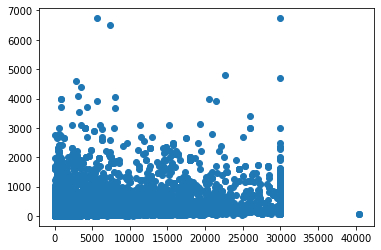

In [14]:
plt.scatter(df['product_weight_g'], df['price'])

In [15]:
df['product_category_name'].value_counts()

cama_mesa_banho                  11115
beleza_saude                      9670
esporte_lazer                     8641
moveis_decoracao                  8334
informatica_acessorios            7827
                                 ...  
la_cuisine                          14
cds_dvds_musicais                   14
pc_gamer                             9
fashion_roupa_infanto_juvenil        8
seguros_e_servicos                   2
Name: product_category_name, Length: 73, dtype: int64

Como os dados estão muito concentrados, vamos analisar uma categoria especifica, a fim de se obter melhores resultados na regressão. Escolhemos a categoria `cama_mesa_banho`.

In [16]:
household = df[df['product_category_name'] == 'cama_mesa_banho']

In [17]:
household

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,volume_cm3,year,month,day,quarter,week,dayofweek
24,14aa47b7fe5c25522b47b4b29c98dcb9,cama_mesa_banho,54.0,630.0,1.0,1100.0,16.0,10.0,16.0,34ded2049fc8446ced02a6bd3dcbdab3,1,1835b56ce799e6a4dc4eddc053f04066,2018-02-09 12:29:52,71.99,12.00,73e3d5eefc213584073f9781dc3e8430,delivered,2018-02-05 12:14:55,2018-02-05 12:29:52,2018-02-06 19:28:40,2018-02-19 21:41:33,2018-03-01 00:00:00,2560.0,2018,2,5,1,6,0
25,14aa47b7fe5c25522b47b4b29c98dcb9,cama_mesa_banho,54.0,630.0,1.0,1100.0,16.0,10.0,16.0,34ded2049fc8446ced02a6bd3dcbdab3,2,1835b56ce799e6a4dc4eddc053f04066,2018-02-09 12:29:52,71.99,12.00,73e3d5eefc213584073f9781dc3e8430,delivered,2018-02-05 12:14:55,2018-02-05 12:29:52,2018-02-06 19:28:40,2018-02-19 21:41:33,2018-03-01 00:00:00,2560.0,2018,2,5,1,6,0
26,14aa47b7fe5c25522b47b4b29c98dcb9,cama_mesa_banho,54.0,630.0,1.0,1100.0,16.0,10.0,16.0,47367d800613791c119ec33ee79cd9f0,1,1835b56ce799e6a4dc4eddc053f04066,2018-06-08 17:31:20,71.99,14.59,212910421824dc61368dd3c1b82c0fce,delivered,2018-05-31 17:07:48,2018-05-31 17:32:59,2018-06-04 12:58:00,2018-06-11 14:32:24,2018-07-04 00:00:00,2560.0,2018,5,31,2,22,3
27,14aa47b7fe5c25522b47b4b29c98dcb9,cama_mesa_banho,54.0,630.0,1.0,1100.0,16.0,10.0,16.0,f544502f7cd11a14cdc792d87c7795d5,1,1835b56ce799e6a4dc4eddc053f04066,2018-08-08 15:30:17,71.99,23.30,c2c015c222df129ec56095380b34a3f0,delivered,2018-08-06 15:14:00,2018-08-06 15:30:17,2018-08-09 12:14:00,2018-08-16 18:24:44,2018-08-17 00:00:00,2560.0,2018,8,6,3,32,0
40,f53103a77d9cf245e579ea37e5ec51f0,cama_mesa_banho,52.0,206.0,1.0,500.0,16.0,10.0,16.0,a4425e2bccba621150a07a685cf063be,1,1835b56ce799e6a4dc4eddc053f04066,2018-06-29 14:57:15,41.99,13.87,d436890d44092b00fcfcbdd7a168c240,delivered,2018-06-26 14:27:52,2018-06-26 14:57:15,2018-06-27 11:31:00,2018-06-29 16:18:52,2018-07-18 00:00:00,2560.0,2018,6,26,2,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112638,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,4c460fdf49b517270b6258ba2d3c1ef9,1,439a47cc365d6e3bd526812ea9de3c29,2018-06-20 18:58:12,127.50,11.91,ffe82abbde8061e75c4c0b72f3b2accf,delivered,2018-06-14 18:37:58,2018-06-14 18:58:12,2018-06-15 14:17:00,2018-06-16 10:12:15,2018-06-29 00:00:00,5103.0,2018,6,14,2,24,3
112639,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,6e4008bddce63615856554f94e5233db,1,439a47cc365d6e3bd526812ea9de3c29,2018-06-28 17:18:27,127.50,11.91,866b8000cd92edc48a379e9672976d05,delivered,2018-06-24 13:59:43,2018-06-24 17:18:27,2018-06-26 08:42:00,2018-06-29 14:35:31,2018-07-12 00:00:00,5103.0,2018,6,24,2,25,6
112640,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,7c8a032bb75e0e4d524b14ba147d4ba5,1,439a47cc365d6e3bd526812ea9de3c29,2017-08-25 15:50:13,127.50,17.14,bc353829b04483f9c7163579f4c52ce1,delivered,2017-08-21 15:37:43,2017-08-21 15:50:13,2017-08-22 15:15:27,2017-08-30 18:08:26,2017-09-13 00:00:00,5103.0,2017,8,21,3,34,0
112641,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,fc957026f2482ab3bddf91ebc9d0dfc5,1,e4ebd3f87bf70440014f07ddda7fbe03,2018-01-16 21:31:29,127.00,12.39,fb39becf0dd61e75a7c3e5bf2642d55b,delivered,2018-01-10 21:19:56,2018-01-10 21:31:35,2018-01-11 17:54:59,2018-01-23 22:58:48,2018-01-31 00:00:00,5103.0,2018,1,10,1,2,2


Vamos dropar as colunas que poderão causar confusão nos regressores.

In [18]:
household = household.drop(
    [
        'product_id',
        'product_category_name',
        'product_name_lenght',
        'product_description_lenght',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'seller_id',
        'order_id',
        'order_item_id',
        'shipping_limit_date',
        'freight_value',
        'customer_id',
        'order_status',
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ],
    axis=1
)

In [19]:
household

,product_photos_qty,product_weight_g,price,volume_cm3,year,month,day,quarter,week,dayofweek
24,1.0,1100.0,71.99,2560.0,2018,2,5,1,6,0
25,1.0,1100.0,71.99,2560.0,2018,2,5,1,6,0
26,1.0,1100.0,71.99,2560.0,2018,5,31,2,22,3
27,1.0,1100.0,71.99,2560.0,2018,8,6,3,32,0
40,1.0,500.0,41.99,2560.0,2018,6,26,2,26,1
...,...,...,...,...,...,...,...,...,...,...
112638,1.0,1400.0,127.50,5103.0,2018,6,14,2,24,3
112639,1.0,1400.0,127.50,5103.0,2018,6,24,2,25,6
112640,1.0,1400.0,127.50,5103.0,2017,8,21,3,34,0
112641,1.0,1400.0,127.00,5103.0,2018,1,10,1,2,2


Então, veremos uma matriz de correlação para observarmos quais dessas colunas provavelmente terão mais impacto no preço.

In [20]:
corr = household.corr()
corr.style.background_gradient(cmap='coolwarm')

,product_photos_qty,product_weight_g,price,volume_cm3,year,month,day,quarter,week,dayofweek
product_photos_qty,1.000000,0.158178,0.100476,0.099507,-0.070033,0.033797,-0.009984,0.042174,0.032517,0.000566
product_weight_g,0.158178,1.000000,0.600576,0.592193,-0.059053,0.038656,0.001535,0.041028,0.038077,0.008438
price,0.100476,0.600576,1.000000,0.457783,-0.023238,0.014397,0.002086,0.016569,0.014258,0.004296
volume_cm3,0.099507,0.592193,0.457783,1.000000,-0.049728,-0.004500,-0.007262,0.000934,-0.005490,0.000117
year,-0.070033,-0.059053,-0.023238,-0.049728,1.000000,-0.580262,-0.052481,-0.561107,-0.578516,-0.021522
month,0.033797,0.038656,0.014397,-0.004500,-0.580262,1.000000,0.022982,0.969251,0.995888,0.030804
day,-0.009984,0.001535,0.002086,-0.007262,-0.052481,0.022982,1.000000,0.034152,0.110822,0.000938
quarter,0.042174,0.041028,0.016569,0.000934,-0.561107,0.969251,0.034152,1.000000,0.966574,0.025511
week,0.032517,0.038077,0.014258,-0.005490,-0.578516,0.995888,0.110822,0.966574,1.000000,0.010499
dayofweek,0.000566,0.008438,0.004296,0.000117,-0.021522,0.030804,0.000938,0.025511,0.010499,1.000000


Vamos remover as colunas que possuem valor absolute de correlação menor que 0.02.

In [21]:
household = household.drop(
    [
        'month',
        'day',
        'quarter',
        'week',
        'dayofweek',
    ],
    axis=1
)

Vamos agora analizar qual conjunto de dados melhor se adequará ao modelo de regressão.

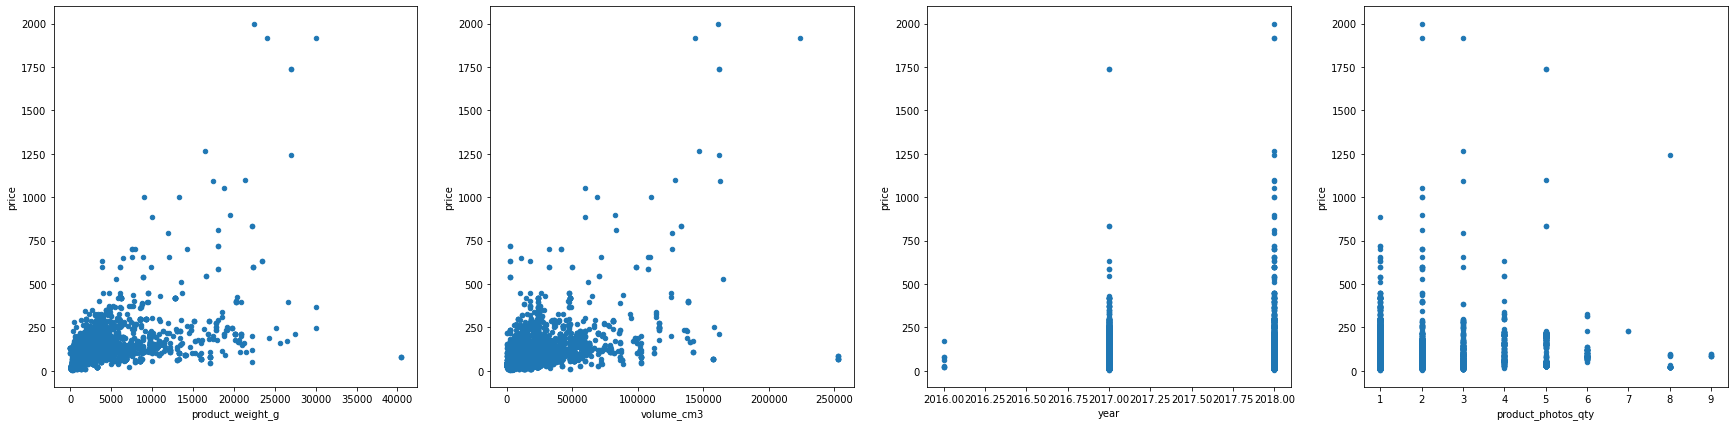

In [22]:
figs, axes = plt.subplots(1, 4, figsize=(30, 7))
household[['product_weight_g', 'price']].plot.scatter(x='product_weight_g', y='price', ax=axes[0])
household[['volume_cm3', 'price']].plot.scatter(x='volume_cm3', y='price', ax=axes[1])
household[['year', 'price']].plot.scatter(x='year', y='price', ax=axes[2])
household[['product_photos_qty', 'price']].plot.scatter(x='product_photos_qty', y='price', ax=axes[3])

# Regressão Linear

Vamos aplicar o modelo de Regressão Linear ao conjunto de dados volume_cm3 x price

Utilizando mlflow para rastrear os dados

In [23]:
pip install mlflow

     |████████████████████████████████| 14.4 MB 61 kB/s 
     |████████████████████████████████| 146 kB 58.7 MB/s 
     |████████████████████████████████| 170 kB 75.4 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.3 MB/s 
     |████████████████████████████████| 636 kB 56.6 MB/s 
     |████████████████████████████████| 75 kB 4.7 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=89e8afc976b923b36b762409461cc06ff8d03ae54ef9ed358ca61d4c046ea559
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=2ceba93105bd95d464a87198a22684583d193f0e5ae0d0d5ec35923e4baa59f5

In [24]:
import mlflow
import mlflow.sklearn

In [25]:
get_ipython().system_raw("mlflow ui --port 5000 &")

In [26]:
pip install pyngrok

     |████████████████████████████████| 746 kB 9.6 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.6-py3-none-any.whl size=19262 sha256=2c9baed74e6b5059fcfa096e9b6f69518a7107145cd53aba51b1cd5be7cf3ec4
  Stored in directory: /root/.cache/pip/wheels/d5/8c/c4/8d9cbca4fa19bf64887b4a91914194bb9033f1a7cbb344d5ab
Successfully built pyngrok


In [27]:
from pyngrok import ngrok

# Finaliza túneis previamente executados, se existirem
ngrok.kill()

# Abre um novo túnel em http://localhost:5000 para URL pública
public_url = ngrok.connect(5000, proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)

MLflow Tracking UI: NgrokTunnel: "http://0aa67b4b5467.ngrok.io" -> "http://localhost:5000"


In [28]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

Dividindo o conjunto de dados

In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(household)

In [30]:
train_x = train['volume_cm3']
test_x = test['volume_cm3']
train_y = train['price']
test_y = test['price']

In [31]:
with mlflow.start_run(run_name="LR"):
    model = LinearRegression(fit_intercept=True)
    model.fit(train_x.values.reshape(-1, 1), train_y.values.reshape(-1, 1))

    predicted = model.predict(test_x.values.reshape(-1, 1))

    (rmse, mae, r2) = eval_metrics(test_y, predicted)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "LR", registered_model_name="LRPriceModel")
    else:
        mlflow.sklearn.log_model(model, "LR")

  RMSE: 76.0196474179096
  MAE: 43.01847508659088
  R2: 0.23107483485333458


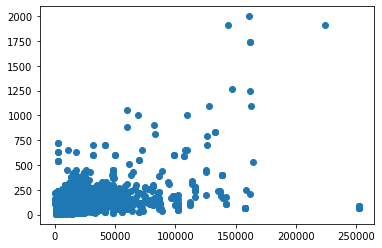

In [32]:

model = LinearRegression(fit_intercept=True)

model.fit(household['volume_cm3'].values.reshape(-1, 1), household['price'].values.reshape(-1, 1))

xfit = np.linspace(0, 16000, 4000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(household['volume_cm3'], household['price'])
plt.plot(xfit, yfit)

Avaliando métricas de desempenho

In [33]:
print("Model inclinação:      {:.3f}".format(model.coef_[0][0]))
print("Model intercepto:     {:.3f}".format(model.intercept_[0]))

Model inclinação:      0.002
Model intercepto:     59.876


MSE e R2 Score

In [34]:
from sklearn.metrics import r2_score, mean_squared_error

l = lambda x: model.coef_[0][0]*x + model.intercept_[0]

mse = mean_squared_error(household['price'], l(household['volume_cm3']))
r2 = r2_score(household['price'], l(household['volume_cm3']))

In [35]:
print("R2 l1:      {:.3f}".format(r2))
print("MSE l3:      {:.3f}".format(mse))

R2 l1:      0.210
MSE l3:      5331.014


Vamos verificar os resíduos com o ajuste da curva

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


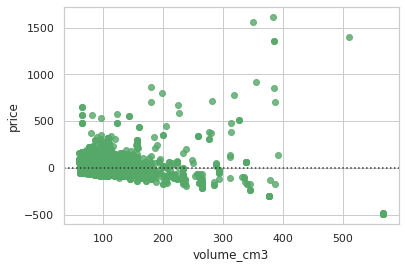

In [36]:
sns.set(style="whitegrid")

# Plotando os resíduos após utilizar a regressão linear
sns.residplot(l(household['volume_cm3']), household['price'], color="g")

Verficando a normalidade

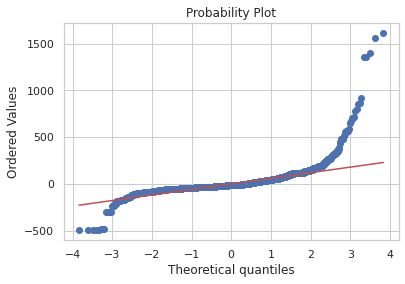

In [37]:
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot((household['price']-l(household['volume_cm3'])), plot=ax, fit=True)

# Regressão Linear Múltipla

In [38]:
train_x = train.drop(['price'], axis=1)
test_x = test.drop(['price'], axis=1)
train_y = train['price']
test_y = test['price']

In [39]:
with mlflow.start_run(run_name="Multi LR"):
    model = LinearRegression(fit_intercept=True)
    model.fit(train_x, train_y)

    predicted = model.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "Multi LR", registered_model_name="ElasticnetPriceModel")
    else:
        mlflow.sklearn.log_model(model, "Multi LR")

  RMSE: 66.50039787987912
  MAE: 36.29716055442348
  R2: 0.411588895567117


# Regressor Ridge

In [40]:
with mlflow.start_run(run_name="Ridge Regressor"):
    model = Ridge()
    model.fit(train_x, train_y)

    predicted = model.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "Ridge Regressor", registered_model_name="RidgeRegressorPriceModel")
    else:
        mlflow.sklearn.log_model(model, "Ridge Regressor")

  RMSE: 66.50040406161901
  MAE: 36.297125874141095
  R2: 0.41158878617214545


# Regressão por Vetor de Suporte

In [41]:
with mlflow.start_run(run_name="SV Regressor"):
    model = SVR()
    model.fit(train_x, train_y)

    predicted = model.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "SV Regressor", registered_model_name="SVRegressorPriceModel")
    else:
        mlflow.sklearn.log_model(model, "SV Regressor")

  RMSE: 76.79352794732954
  MAE: 33.773777626627165
  R2: 0.21533982233061333


# Regressor de Floresta Aleatória


In [42]:
with mlflow.start_run(run_name="RF Regressor"):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)

    predicted = model.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "RF Regressor", registered_model_name="RFRegressorPriceModel")
    else:
        mlflow.sklearn.log_model(model, "RF Regressor")

  RMSE: 43.967431815238214
  MAE: 10.709846671024343
  R2: 0.7427860196443303
